In [1]:
import numpy as np
from matplotlib import pyplot as plt

import pickle as pkl
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from FormationControl import formation_control_force
from GradientEstimation import grad_est
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter
from utils.FIMPathPlanning import FIM_ascent_path_planning 
from utils.dLdp import dLdp
from utils.regions import CircleExterior
from tracking_log import logger

style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

## Plotting Utilities

In [2]:
def plot_trajectory(ax,traj,name,marker,size=50):
    def direction_at(i):
        direction = traj[i+1,:]-traj[i,:]
        return traj[i,0],traj[i,1], direction[0],direction[1]

    ax.scatter(traj[:,0],traj[:,1],label=name,marker=marker,s = size)
	


    
def plot_dist_to_source(ax,log):
    src_locs = log['src_locs']['source_1']
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(src_locs)])
        dist = np.linalg.norm(sensor_locs[:l]-src_locs[:l],axis = 1)
        ax.plot(dist,label = key)
    ax.set_title('Sensor-Source Distance vs Time steps',fontsize=15)
    ax.set_xlabel('Time Steps')
#     ax.legend()
    
def plot_L(ax,log):
    q = log['src_locs']['source_1']
    ps = []
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(q)])
        ps.append(sensor_locs[:l])
    ps = np.hstack(ps).reshape(-1,3,2)
    Ls = [f_L(q[i,:],ps[i,:]) for i in range(l)]
    ax.plot(np.log(Ls),label = r'$\log(L(p,q))$')
    
    for key,qhat in log['est_locs_log'].items():
        if key in["ekf"]:            
            Lhat = [f_L(qhat[i,:],ps[i,:]) for i in range(l)]
            ax.plot(np.log(Lhat),label = r'$\log(L(p,qhat))$')
      
    ax.legend(loc='lower right')
#     ax.set_title('log(L(ps,q)) vs Time steps',fontsize=15)
    ax.set_ylabel('log loss')

def plot_all(log,main_title,save_file_name):
    fig = plt.figure(dpi=100,figsize=(10,10))
    gs = fig.add_gridspec(2,1)

    
    ax = fig.add_subplot(gs[0,:])
    rectangle = plt.Rectangle((0,0), 3, 3, alpha=0.3,fc='red',ec="red")
    ax.add_artist(rectangle)
    ax.text(0.5,1.5,'Starting Region of the Sensors')
    plot_experiment(ax,log)
    
    ax = fig.add_subplot(gs[1,:])
    plot_dist_to_source(ax,log)
    
    
    ax.set_title(main_title,fontsize=20)
    
    fig.tight_layout()

    plt.savefig(save_file_name,bbox_inches='tight')


# animation function. This is called sequentially
def plot_experiment(ax,log):
#     ax.clear()

#     ax.set_xlim((0,7))
#     ax.set_ylim((0,7))

    ax.set_aspect('equal',adjustable='box')
           
    
    for key,val in log['src_locs'].items():
        plot_trajectory(ax,val,'Static Source','*',size = 400)

    for key,val in log['sensor_locs'].items():
        plot_trajectory(ax,val,key,'.',size=200)
    for key,val in log['virtual_leader_locs'].items():
        plot_trajectory(ax,val,key,'+',size=200)
    

    ax.legend(loc='right')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    

In [3]:
def random_initial_poses(n_sensors,xmin,xmax,ymin,ymax):
    sensor_poses = np.zeros((n_sensors,2))
    sensor_poses[:,0]= xmin + np.random.rand(n_sensors)*(xmax-xmin)
    sensor_poses[:,1]= ymin + np.random.rand(n_sensors)*(ymax-ymin)
    return sensor_poses

## Main Loop

In [24]:
def main(n_sensors,std, N):
    # Set up mobile sensors and sources
    src_locs = [[6.,6]]
    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    initial_locs = random_initial_poses(n_sensors,xmin=0,xmax=3,ymin=0,ymax=3)
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(initial_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(initial_locs,sensor_names)]

    CoM = np.mean(initial_locs,axis=0)

    ## Set up virtual leaders. Required for sensors' motion control.
    # Create a circular formation of virtual leaders centered at the CoM of mobile sensors, with one virtual leader at the CoM of the sensors.

    n_virtual_leaders = 1 # Only 1 virtual leader gives a much stabler formation than other # of virtual leaders.

    R0 = 0.8 # If there are more than 1 virtual leaders, this specifies the distance between them.

    if n_virtual_leaders>1:
        thetas = [2*np.pi/(n_virtual_leaders-1)*i for i in range(n_virtual_leaders-1)]
        vl_locs = np.vstack([CoM,CoM+ R0*np.array(np.vstack([np.cos(thetas),np.sin(thetas)]).T)])
    else:
        vl_locs = np.array([CoM])
    vl_names = ["virtual_leader_{}".format(i+1) for i in range(n_virtual_leaders)]
    virtual_leaders = [Robot(loc,name) for loc,name in zip(vl_locs,vl_names)]

    alpha = 0.1 # The overall strength of the control force/potential
    k=1 # Determines how quickly the potential dies down to 0, in the order of 1/r^k.
    d0 = 0.8 # The equilibrium distance between sensors/virtual leaders.
    d1=100 # The distance above which the influence between sensors vanishes to 0.
    kD=0.2 # Dampening term on the sensor velocity, to achieve asymptotic stability.
    max_force=1 # A cap on the control force, to avoid pathological behavior.
    control_force = lambda robot_locs,robot_vels:formation_control_force(robot_locs,robot_vels,alpha,k,d0,d1,kD,max_force)

    max_vl_vel = 0.3

    min_vl_vel = 0.2

    ## Set up virtual sensors
    C1=0
    C0=0
    k=1
    b=-2
    vs = virtual_sensor(C1,C0,b,k,std)

    # Set up data logger
    log = logger(sensor_names,src_names,vl_names)

    # Main Loop
   

    for _ in range(N):


        # Record
        for s in source:
            log.src_locs[s.name].append(s.loc)

        for m in mobile_sensors:
            log.sensor_locs[m.name].append(m.loc)

        for v in virtual_leaders:
            log.virtual_leader_locs[v.name].append(v.loc)

        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])
        y = vs.measurement(qs,ps)

        # Gradient estimation.
        grad,_=grad_est(ps,y)
        # Virtual leader movement.
    #     grad = np.array([0.1,0.1])*1
        grad_mag = np.linalg.norm(grad)

        if grad_mag>max_vl_vel: # Cap the magnitude of gradient update by max_vl_vel. This slows down the virtual leader and allows the sensors to stabilize.
            grad=grad/grad_mag * max_vl_vel
        elif grad_mag<min_vl_vel: # This keeps the virtual leader to move at a reasonable speed when the gradient is small.
            grad=grad/grad_mag * min_vl_vel

        for v in virtual_leaders:
            v.update_loc(v.loc+grad)

        ## The section of sensor motion control, using artificial potential and virtual leaders.

        vl_states = np.array([[v.loc,v.vel] for v in virtual_leaders])
        sensor_states = np.array([[r.loc,r.vel] for r in mobile_sensors])
        robot_locs = np.vstack([vl_states[:,0,:],sensor_states[:,0,:]])
        robot_vels = np.vstack([vl_states[:,1,:],sensor_states[:,1,:]])

        sensor_indx = np.arange(n_virtual_leaders,len(robot_locs),1)
        f = control_force(robot_locs,robot_vels)

        f_m = f[sensor_indx] # Only the mobile sensors are subject to the control force. The virtual leaders are not.
        for m,f in zip(mobile_sensors,f_m):
            m.update_vel(m.vel-f) #dv/dt = -f
            m.update_loc(m.loc+m.vel) #dx/dt = v

        ## Formation control ends.
    return log


## Run experiments and save data

In [21]:
def get_dists_to_src(log):
    src_locs = log['src_locs']['source_1']
    dists = []
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(src_locs)])
        dists.append(np.linalg.norm(sensor_locs[:l]-src_locs[:l],axis = 1))
    return np.array(dists)

In [4]:
# Experiment parameters
noise_std = 0.01
N_steps = 100
N_expr = 100
N_sensors = [3,10,20,50]

In [68]:

# Data container
experiment = {n:[] for n in N_sensors}

for n_sensors in N_sensors:
    dists = []
    for _ in range(N_expr):
        log=main(n_sensors,noise_std,N_steps)
        dists.append(get_dists_to_src(log.export()))
    data = {'format':'dists[num_experiments,n_sensor,N_steps]','data':np.array(dists)}
    experiment[n_sensors]=data

In [69]:
filename = 'NaomiDists.pkl'
pkl.dump(experiment,open(filename,'wb'))

In [7]:
filename = 'NaomiDists.pkl'
experiment = pkl.load(open(filename,'rb'))

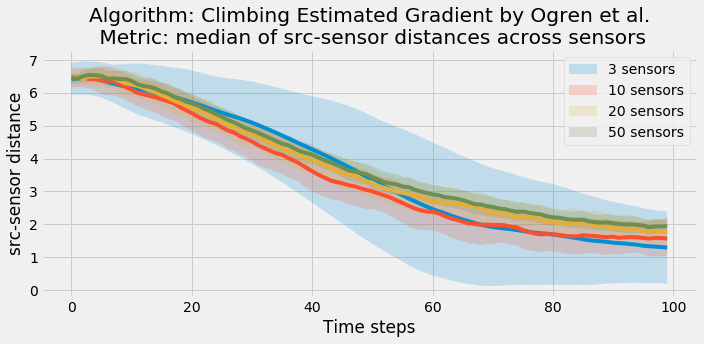

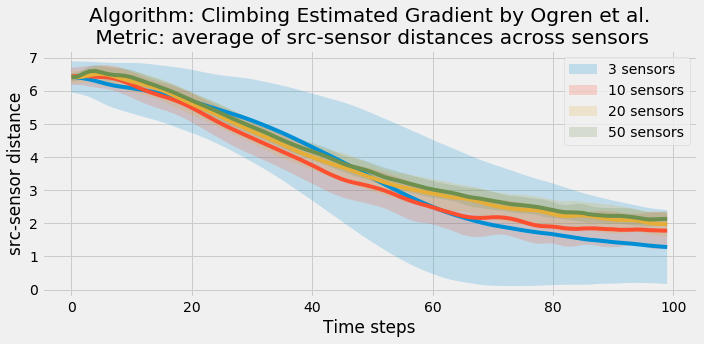

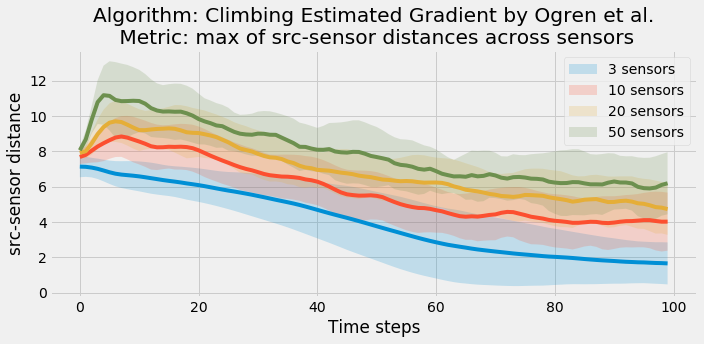

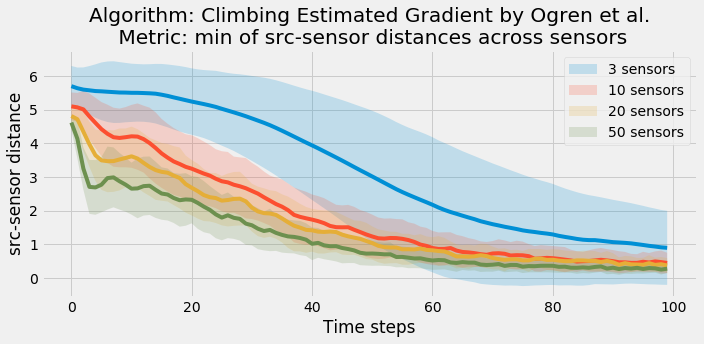

In [8]:
metrics = {'median':np.median,'average':np.mean,'max':np.max,'min':np.min}
for metric_name,metric_method in metrics.items():
    plt.figure(figsize=(10,5))
    for n_sensor in N_sensors:
        metric = metric_method(experiment[n_sensor]['data'],axis=1)
        dist = np.mean(metric,axis=0)
        sd = np.std(metric,axis = 0)
        x=range(len(dist))
        plt.plot(x,dist)
        plt.fill_between(x,dist-sd,dist+sd,alpha=0.2,label = '{} sensors'.format(n_sensor))
    plt.xlabel('Time steps')
    plt.ylabel('src-sensor distance')
    plt.title("Algorithm: Climbing Estimated Gradient by Ogren et al.\n Metric: {} of src-sensor distances across sensors".format(metric_name))
    plt.legend()
    plt.tight_layout()
    plt.savefig("Naomi{}.png".format(metric_name))
    plt.show()